# Module 02_02: SVC: targeting CPU and Patching 

![Assets/SVCacceleration.jpg](Assets/SVCacceleration.jpg)


# Learning Objectives:

1) Describe how to surgically unpatch specific optimized functions if needed
2) Describe differences in patching more globally versus more surgically
1) applied patching to SVC algorithm
2) Describe acceleration for the covtype dataset usinf SVC



# Connect4 Game Play Dataset

### Compare timings of stock kmeans versus Intel Extension for Scikit-learn SVC using patch_sklean()

Below we will apply Intel Extension for Scikit learn to a use case on a CPU

Intel® Extension for Scikit-learn contains drop-in replacement functionality for the stock scikit-learn package. You can take advantage of the performance optimizations of Intel Extension for Scikit-learn by adding just two lines of code before the usual scikit-learn imports. Intel® Extension for Scikit-learn patching affects performance of specific Scikit-learn functionality.

### Data: connect4

We will use Data Set Information:

This database contains all legal 8-ply positions in the game of connect-4 in which neither player has won yet, and in which the next move is not forced.

**x** is the first player; **o** the second.

The outcome class is the game theoretical value for the first player.

Attribute Information:

Attribute Information: (x=player x has taken, o=player o has taken, b=blank)

The board is numbered like:
6 . . . . . . .
5 . . . . . . .
4 . . . . . . .
3 . . . . . . .
2 . . . . . . .
1 . . . . . . .
a b c d e f g

1. a1: {x,o,b}
2. a2: {x,o,b}
3. a3: {x,o,b}
4. a4: {x,o,b}

### Overview of procedure
In the below example we will train and predict kNN algorithm with Intel Extension for Scikit-learn for covtype dataset and calculate the CPU and wall clock time for training and prediction. Then in the next step we will unpatch the Intel extension for Scikit-learn and observe the time taken on the CPU for the same trainng and prediction.

### Fetch the Data

- [Back to Sections](#Back_to_Sections)


In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import pandas as pd
import time
import numpy as np
import numpy.ma as ma

connect4 = pd.read_csv('data/connect-4.data')

data = connect4.iloc[:,:42].replace(['x', 'o', 'b'], [0,1,2])

keep = .25 # amount of data to experiment with to keep times reasonable
subsetLen = int(keep*data.shape[0])

X = np.byte( data.iloc[:subsetLen,:].to_numpy() )
X = X[:subsetLen,:42]
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X)
enc.categories_

XOHE = np.short(enc.transform(X).toarray() )# X one hot encoded

Data_y = connect4.iloc[:,42].to_numpy()
#np.random.shuffle(Data_y)
y =  Data_y[:subsetLen] 

import sklearn.model_selection as model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(XOHE, y, train_size=0.80, test_size=0.20, random_state=101)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from sklearn.metrics import classification_report

def predict( linear ):
    import numpy as np
    time_patch_predict = time.time()
    y_pred = linear.predict(X_test)
    elapsed = time.time() - time_patch_predict
    return elapsed, y_pred

def fit():
    start = time.time()
    linear = svm.SVC(kernel='linear', C=100).fit(X_train, y_train)
    time_patch_fit =  time.time() - start
    return time_patch_fit, linear


# Exercise:

Apply unpatch

In [3]:
from sklearn.metrics import classification_report

# Apply the unpatch_sklearn() function to this cell then run the cell and note the time:

###############################
## add unpatch here ##
from sklearnex import patch_sklearn, unpatch_sklearn 
unpatch_sklearn()
###############################
from sklearn import svm
unpatch_time_fit, linear = fit()
unpatch_time_predict, y_pred = predict(linear)
target_names = ['win', 'loss', 'draw']
print("file as is ")
print(classification_report(y_test, y_pred, target_names=target_names))
print('Elapsed time: {:.2f} sec'.format( unpatch_time_fit + unpatch_time_predict))

file as is 
              precision    recall  f1-score   support

         win       0.45      0.02      0.04       231
        loss       0.68      0.59      0.63       614
        draw       0.85      0.95      0.89      2533

    accuracy                           0.82      3378
   macro avg       0.66      0.52      0.52      3378
weighted avg       0.79      0.82      0.79      3378

Elapsed time: 79.45 sec


# Exercise:

Apply patch below

In [4]:
from sklearn.metrics import classification_report

# Apply the patch_sklearn() function to this cell then run the cell and note the time:

###############################
## add patch here ##
patch_sklearn()

###############################
from sklearn import svm
patch_time_fit, linear = fit()
patch_time_predict, y_pred = predict(linear)
target_names = ['win', 'loss', 'draw']
print("file as is ")
print(classification_report(y_test, y_pred, target_names=target_names))
print('Elapsed time: {:.2f} sec'.format( patch_time_fit + patch_time_predict))

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


file as is 
              precision    recall  f1-score   support

         win       0.45      0.02      0.04       231
        loss       0.68      0.59      0.63       614
        draw       0.85      0.95      0.89      2533

    accuracy                           0.82      3378
   macro avg       0.66      0.52      0.52      3378
weighted avg       0.79      0.82      0.79      3378

Elapsed time: 11.98 sec


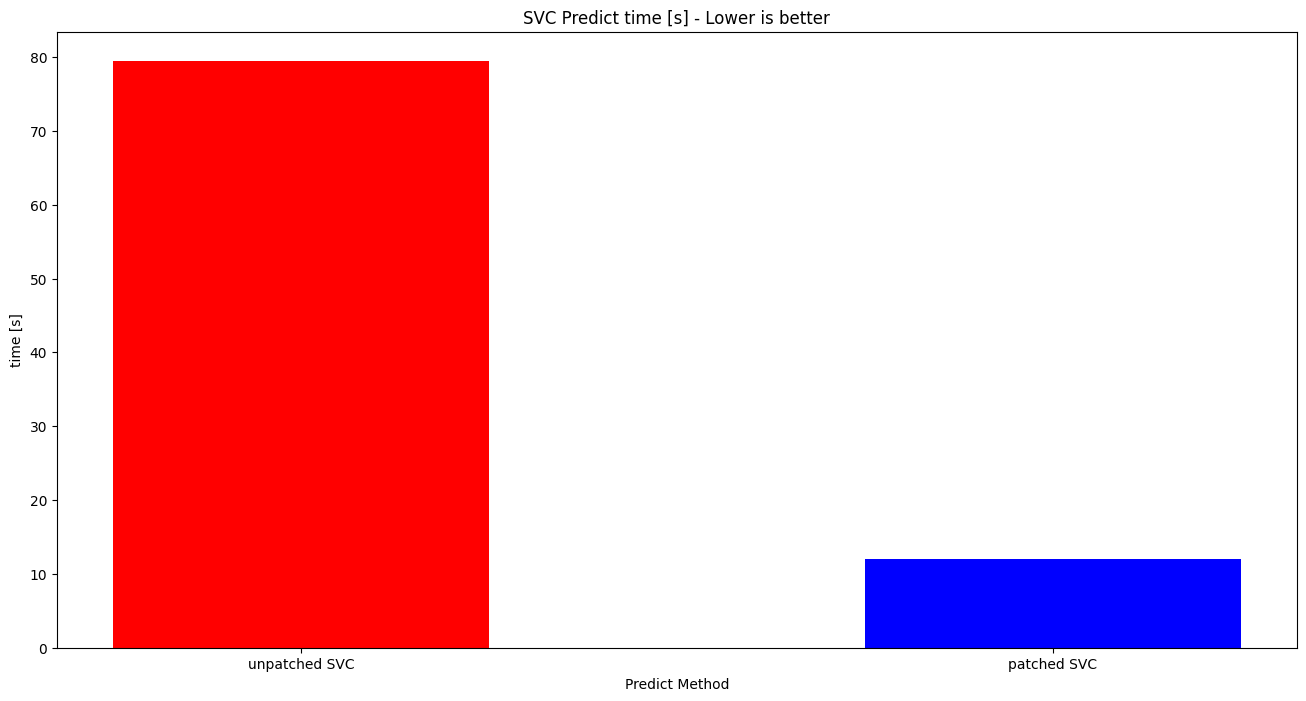

Intel(R) Extensions for scikit-learn*  SVC Speedup  6.6 x!


In [5]:
# Copyright 2022 Intel Corporation
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
%matplotlib inline
import matplotlib.pyplot as plt

left = [1,2]
pred_times = [unpatch_time_fit + unpatch_time_predict, patch_time_fit + patch_time_predict]
tick_label = ['unpatched SVC', 'patched SVC']
plt.figure(figsize = (16,8))
plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['red', 'blue'])
plt.xlabel('Predict Method'); plt.ylabel('time [s]'); plt.title('SVC Predict time [s] - Lower is better')
plt.show()

print('Intel(R) Extensions for scikit-learn* \033[1m SVC Speedup {:4.1f} x!\033[0m'.format( (unpatch_time_fit + unpatch_time_predict)/(patch_time_fit + patch_time_predict)))

Compare the times and accuracies of these two runs. 

Is the time versus accuracy trade off worth the effort to patch this function?

Reminder of how to find the list of functions available to patch


# Summary:

You have:

1) applied patching to SVC algorithm
2) Describe acceleration for tehe covtype dataset
    

# Notices & Disclaimers 

Intel technologies may require enabled hardware, software or service activation.
No product or component can be absolutely secure.

Your costs and results may vary.

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. 
*Other names and brands may be claimed as the property of others.

In [6]:
print("All Done")

All Done
